<a href="https://colab.research.google.com/github/rafaelsetti7/Data-Science-Projects/blob/main/NLP_Tokemize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primeiramente, vamos importar as bibliotecas para dar procedimento a análise:

In [ ]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Em seguida, vamos carregar o data frame:

In [ ]:
df = pd.read_csv('labeled_data.csv', sep = ",")
df.head()

,title,plot_synopsis,cult,horror,gothic,murder,atmospheric,violence,romantic,inspiring,stupid,feel,good,cruelty,dramatic,action,revenge,sadist,queer,flashback,mystery,suspenseful,neo,noir,prank,psychedelic,tragedy,autobiographical,home,movie,versus,evil,depressing,realism,boring,haunting,sentimental,paranormal,historical,storytelling,...,cute,entertaining,bleak,humor,plot,twist,christian,film,pornographic,insanity,brainwashing,sci,fi,dark,claustrophobic,psychological,melodrama,fiction,absurd,satire,alternate,reality,history,comic,grindhouse,thought,provoking,clever,western,blaxploitation,whimsical,intrigue,allegory,anti,war,avant,garde,suicidal,magical,non
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...",0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...",1,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Então, para ilustrar as observações, ve-se o titulo e a sinópse para o primeiro registro:

In [ ]:
df.loc[0, 'title'], df.loc[0, 'plot_synopsis']

('I tre volti della paura',
 'Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the \'Three Faces of Fear\'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl who returns to her spacious, basement apartment after an evening out when she immediately gets beset by a series of strange phone calls. The caller soon identified himself as Frank, her ex-pimp who has recently escaped from prison. Rosy is terrified for it was her testimony that landed the man in jail. Looking for solace, Rosy phones her lesbian lover Mary (Lynda Alfonsi). The two women have been estranged for some time, but Rosy is certain that she is the only one who can help her. Mary agrees to come over that night. Seconds later, Frank calls again, promising that no matter who she calls for protection, he will have his revenge. Unknown to Rosy, Mary is the call

Além disso, o df é composto por outros 82 gêneros.

Uma visão geral de nosso df para investigar se existem observações ausentes:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9828 entries, 0 to 9827
Data columns (total 84 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             9828 non-null   object
 1   plot_synopsis     9828 non-null   object
 2   cult              9828 non-null   int64 
 3   horror            9828 non-null   int64 
 4   gothic            9828 non-null   int64 
 5   murder            9828 non-null   int64 
 6   atmospheric       9828 non-null   int64 
 7   violence          9828 non-null   int64 
 8   romantic          9828 non-null   int64 
 9   inspiring         9828 non-null   int64 
 10  stupid            9828 non-null   int64 
 11  feel              9828 non-null   int64 
 12  good              9828 non-null   int64 
 13  cruelty           9828 non-null   int64 
 14  dramatic          9828 non-null   int64 
 15  action            9828 non-null   int64 
 16  revenge           9828 non-null   int64 
 17  sadist        

Conforme observado, percebemos que nosso df é composto por 9828 observações para cada uma das variáveis (tanto para o título e a sinopse, quanto para todos os gêneros). O que facilita nosso tratamento prévio dos dados.

Em seguida, faremos uma análise descritiva da incidência de cada um dos gêneros observados em nosso data frame:

In [ ]:
df_genre = df.drop(['plot_synopsis', 'title'], axis=1)
contador = []
categories = list(df_genre.columns.values)
for i in categories:
    contador.append((i, df_genre[i].sum()))
df_cont = pd.DataFrame(contador, columns=['genero', 'contagem'])
df_cont

,genero,contagem
0,cult,1755
1,horror,329
2,gothic,305
3,murder,3768
4,atmospheric,263
...,...,...
77,avant,159
78,garde,159
79,suicidal,36
80,magical,32


Com o respectivo histograma:



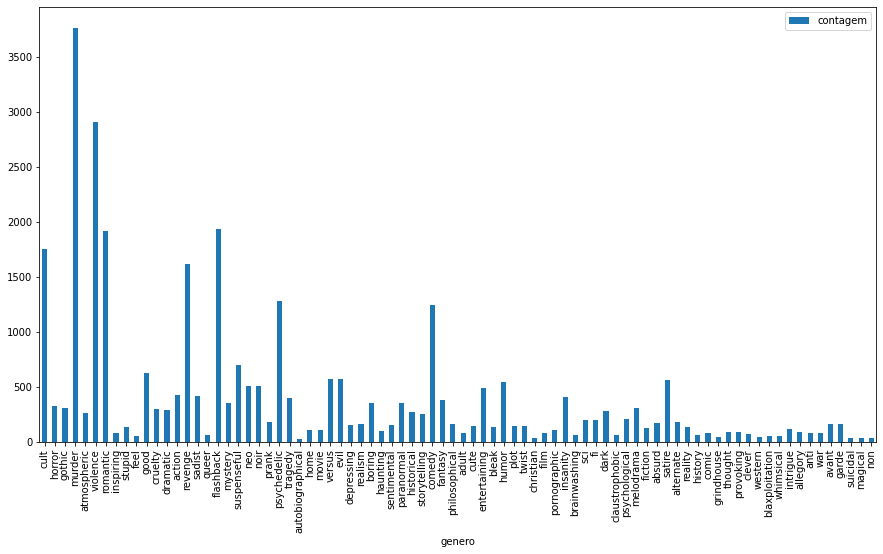

In [ ]:
df_cont.plot(x='genero', y='contagem', kind='bar', figsize=(15,8))
plt.savefig(f"/content/hist1.png")

A partir do histograma, é possível já perceber que "murder" é o gênero que mais aparece entre os filmes do nosso data frame. E, "cult", "violence", "romantic", "revenge", "flashback", "psychedelic" e "comedy" também se ressaltam dos demais gêneros, já que aparecem acima de um patamar próximo a 500 filmes.
Além disso é importante perceber que não há incidência de algum gênero que não foi incluido em nenhum filme. Ou seja, não há gêneros com soma nula.

Agora, vamos ver a quantidade de generos por filme:

In [ ]:
categ_columns = df.columns.drop(['title', 'plot_synopsis'])
for col in categ_columns:
    df[col] = df[col].astype('category')

In [ ]:
soma_filmes = df[categ_columns].sum(axis=1)
df_gpm = pd.DataFrame({'n_filmes': df.title, 'n_tags':soma_filmes}).groupby('n_tags').count()
df_gpm

,n_filmes
n_tags,
1.0,3427
2.0,1995
3.0,1266
4.0,855
5.0,644
6.0,450
7.0,304
8.0,256
9.0,167


Aqui, podemos ver quantos filmes possuem quantas palavras de acordo com nosso data frame "df_gpm".
Sendo assim, faz-se novamente um histograma para entender a frequência do numero de palavras em cada filme:

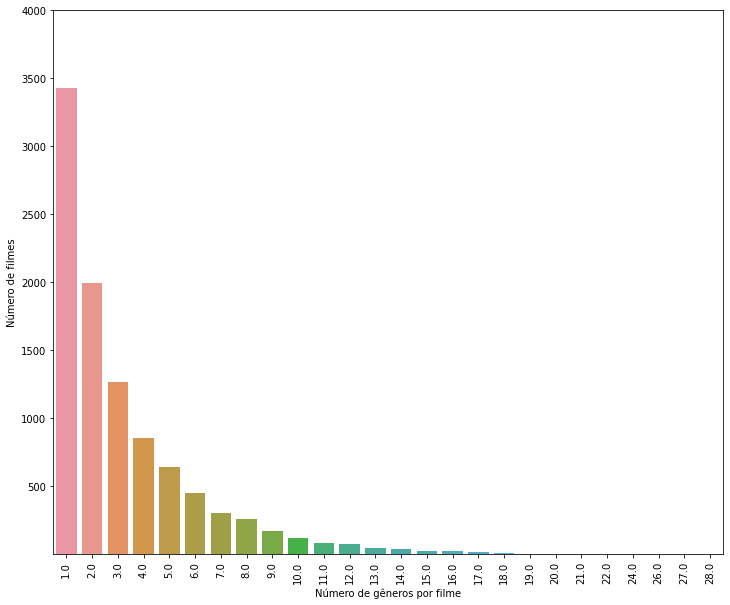

<Figure size 432x288 with 0 Axes>

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_gpm, x=df_gpm.index, y='n_filmes', axes=ax)
ax.set(ylim=(1, 4000), xlabel='Número de gêneros por filme',
       ylabel='Número de filmes')
plt.xticks(rotation=90)
plt.show()
plt.savefig(f"/content/hist2.png")


Observa-se que a frequência dos filmes segue uma curva próxima a uma curva logarítimica. O que posteriormente, pode nos indiciar uma possível transformação nos dados a fim de encaixar a um melhor modelo preditivo.

Faz-se a média do número de gêneros por filme para entender essa medida:

In [ ]:
soma_filmes.mean()

3.2723850223850226

Como indicado, a média de gêneros por filme em nosso data frame é de aproximadamente **3,27** gêneros por filme.

Também é interessante para nossa análise prévia, entender como se estabeleseem as relações inter gênero. Ou seja, entender a correlação dos gêneros entre cada um.
Para isso, faz-se um gráfico de correlação:

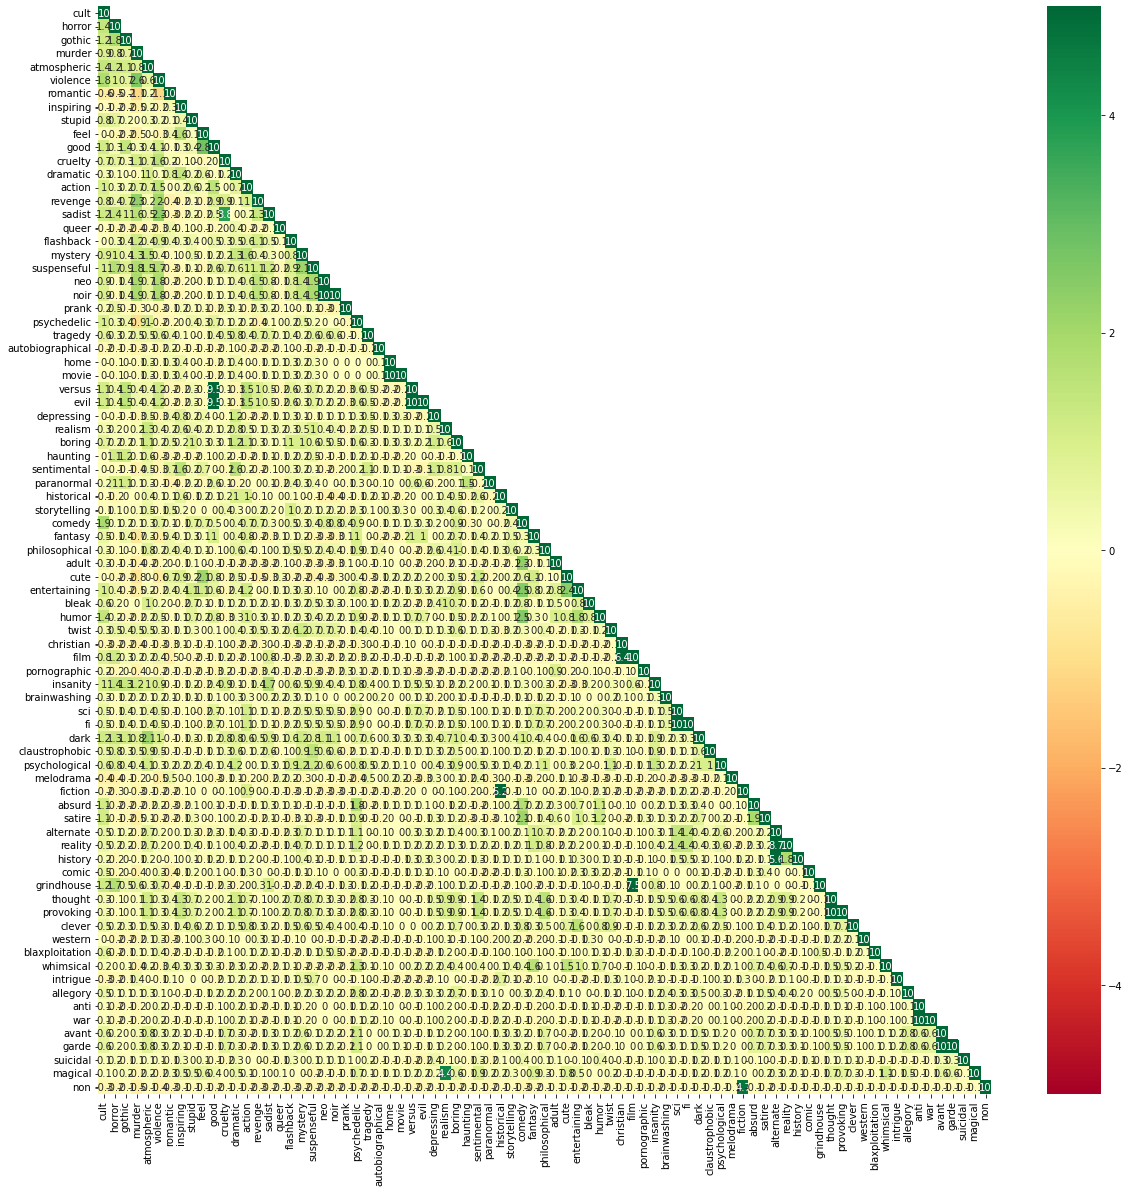

<Figure size 432x288 with 0 Axes>

In [ ]:
categ_columns2 = df.drop(['plot','title','plot_synopsis'], axis=1)

# Heatmap relative to all numeric columns
corr_matrix = (categ_columns2.astype('int')).corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
corr_matrix = (100*corr_matrix//1)/10

fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cbar=True, vmax=5, vmin=-5, cmap='RdYlGn')
plt.show()
plt.savefig(f"/content/corr.png")


Como temos vários gêneros, não é possível visualizar ao certo quais dos gêneros são mais correlacionados entre si. Contudo é possível notar a existência de generos correlacionados entre si, o que nos faz esperar predizões que possivelmente contenham duas ou mais dessas tags correlacionadas.

Agora, vamos limpar um pouco da coluna "plot_synopsis", removendo tudo o que não for caracter e eliminando possíveis contagens de letras maiúsculas:

In [ ]:
def Rtext(texto):
    texto = re.sub("[^a-zA-Z]"," ",texto)
    texto = texto.lower()

    return texto

Agora, aplicamos para todo o data frame:

In [ ]:
df['plot'] = df['plot_synopsis'].apply(lambda x: Rtext(x))
df['plot']

0       note  this synopsis is for the orginal italian...
1       two thousand years ago  nhagruul the foul  a s...
2       matuschek s  a gift store in budapest  is the ...
3       glenn holland  not a morning person by anyone ...
4       in may       a cuban man named tony montana  a...
                              ...                        
9823    opera singer mary barrett  grace moore  leaves...
9824    three criminals  ray  pluto and fantasia  ray ...
9825    in      russ richards  john travolta   the wea...
9826    steven kenet catches his unfaithful wife in th...
9827    sometime in the     s in chicago a man  cecil ...
Name: plot, Length: 9828, dtype: object

Conforme indicado, conseguimos eliminar os caracteres maiúsculos e os caracteres que não são do alfabeto.

Vamos ver como se comportam nossas palavras que constroem a sinópse do filme em um histograma:

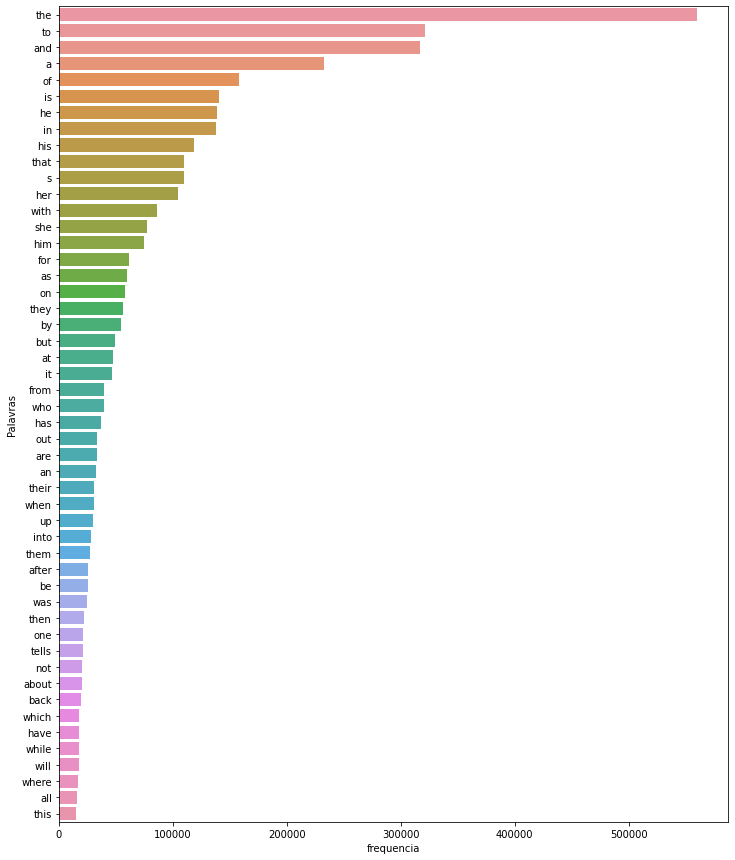

<Figure size 432x288 with 0 Axes>

In [ ]:
  palavras = ' '.join([text for text in df['plot']])
  palavras = palavras.split()
  fdist = nltk.FreqDist(palavras)

  #data frame
  words_df = pd.DataFrame({'palavra':list(fdist.keys()), 'frequencia':list(fdist.values())})
  d = words_df.nlargest(columns="frequencia", n = 50)

  #plot
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "frequencia", y = "palavra")
  ax.set(ylabel = 'Palavras')
  plt.show()
  plt.savefig(f"/content/hist3.png")



Percebe-se que as palavras com maior frequência são palavras de ligação, que podem ser identificadas e removidas através da função stopwords:





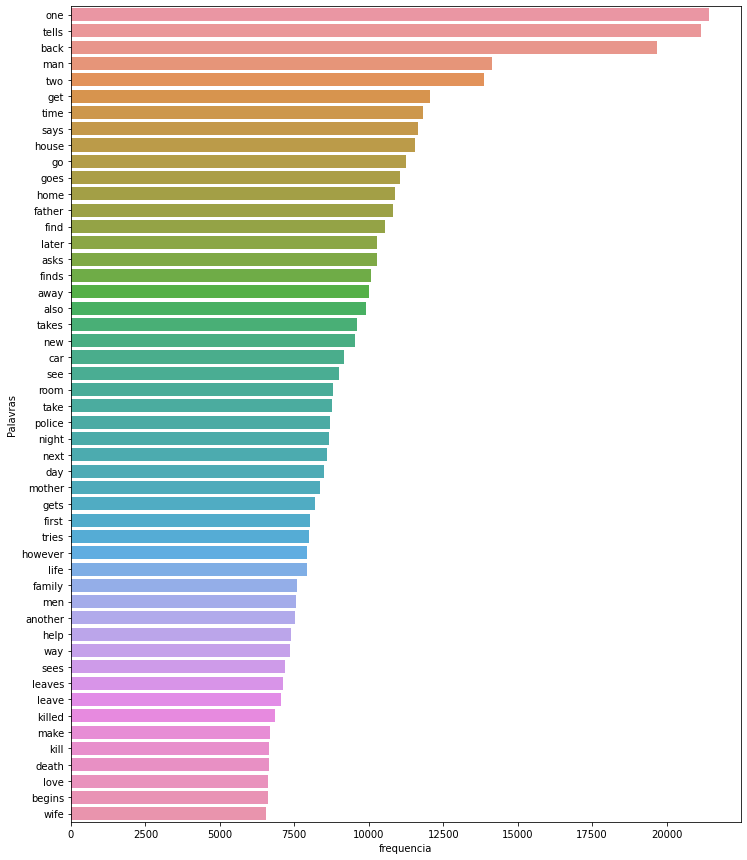

<Figure size 432x288 with 0 Axes>

In [ ]:
stop_words = set(stopwords.words('english'))

def remove_stop(text):
    stopwords_df = [w for w in text.split() if not w in stop_words]
    return ' '.join(stopwords_df)

df['plot'] = df['plot'].apply(lambda x: remove_stop(x))

# histograma sem stopwords
palavras = ' '.join([text for text in df['plot']])
palavras = palavras.split()
fdist = nltk.FreqDist(palavras)

#data frame
words_df = pd.DataFrame({'palavra':list(fdist.keys()), 'frequencia':list(fdist.values())})
d = words_df.nlargest(columns="frequencia", n = 50)

#plot
plt.figure(figsize=(12,15))
ax = sns.barplot(data=d, x= "frequencia", y = "palavra")
ax.set(ylabel = 'Palavras')
plt.show()
plt.savefig(f"/content/hist4.png")


A partir do segundo histograma, é possível observar que as "stopwords" foram removidas, o que é esperado que aumente a acurácia do nosso modelo preditivo.

In [ ]:
tfidf = TfidfVectorizer(analyzer='word', max_features=10000,ngram_range=(1,3))

Como a proposta é usar todo o banco de dados para o conjunto de treinamento, vamos ajustar um modelo com o data frame particionado em 1% direcionado ao conjunto de teste, apenas para podermos extrair as métricas de acurácia do modelo:

In [ ]:
y = categ_columns2.to_numpy()
y = y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(df['plot'], y, test_size=0.01, random_state=9)

In [ ]:
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

O primeiro modelo que vamos ajustar é um modelo de classificação baseado em regressão logística:

In [ ]:
lr = LogisticRegression(solver="lbfgs")
sgd = SGDClassifier()
clf1 = OneVsRestClassifier(lr)
clf2 = OneVsRestClassifier(sgd)
xgb1 = xgb.XGBClassifier()


clf1.fit(x_train_tfidf, y_train)
clf2.fit(x_train_tfidf, y_train)

OneVsRestClassifier(estimator=SGDClassifier())

In [ ]:
y_pred1 = clf1.predict(x_test_tfidf)
y_pred1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_pred2 = clf2.predict(x_test_tfidf)
y_pred2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Com a seguinte medida de acurácia do modelo preditivo via regressão logística:

In [ ]:
f1_score(y_test, y_pred1, average="micro")

0.16

E, para o modelo via SGDClassifier:

In [ ]:
f1_score(y_test,y_pred2,average="micro")

0.19746835443037974

Em seguida, vamos ajustar um modelo XBoost:

In [ ]:
xgb1.fit(x_train_tfidf, y_train)

ValueError: ignored

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-latex-extra set to manually installed.
texlive-xetex is already the newest version (2017.20180305-1).
The following NEW packages will be installed:
  texlive
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 14.4 kB of archives.
After this operation, 70.7 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 texlive all 2017.20180305-1 [14.4 kB]
Fetched 14.4 kB in 0s (371 kB/s)
Selecting previously unselected package texlive.
(Reading database ... 181407 files and directories currently installed.)
Preparing to unpack .../texlive_2017.20180305-1_all.deb ...
Unpacking texlive (2017.20180305-1) ...
Setting up texlive (2017.20180305-1) ...
  Created wh

In [ ]:
!jupyter nbconvert --to latex "/content/Lista3_Mineracao (3).ipynb"

[NbConvertApp] Converting notebook /content/Lista3_Mineracao (3).ipynb to latex
[NbConvertApp] Support files will be in Lista3_Mineracao (3)_files/
[NbConvertApp] Making directory /content/Lista3_Mineracao (3)_files
[NbConvertApp] Making directory /content/Lista3_Mineracao (3)_files
[NbConvertApp] Making directory /content/Lista3_Mineracao (3)_files
[NbConvertApp] Making directory /content/Lista3_Mineracao (3)_files
[NbConvertApp] Making directory /content/Lista3_Mineracao (3)_files
[NbConvertApp] Writing 69446 bytes to /content/Lista3_Mineracao (3).tex
